# 2 Models

In [2]:
import pandas as pd

# Load the data
data = pd.read_csv('../data/curated/preprocessed properties.csv')


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price (AUD per week)   988 non-null    float64
 1   bedrooms               988 non-null    float64
 2   bathrooms              988 non-null    int64  
 3   parkings               988 non-null    int64  
 4   property type          988 non-null    object 
 5   address                988 non-null    object 
 6   suburb                 988 non-null    object 
 7   postcode               988 non-null    int64  
 8   additional features    988 non-null    object 
 9   property url           988 non-null    object 
 10  full_address           988 non-null    object 
 11  latitude               988 non-null    float64
 12  longitude              988 non-null    float64
 13  min_train_dist         988 non-null    float64
 14  closest_train_station  988 non-null    object 
 15  price 

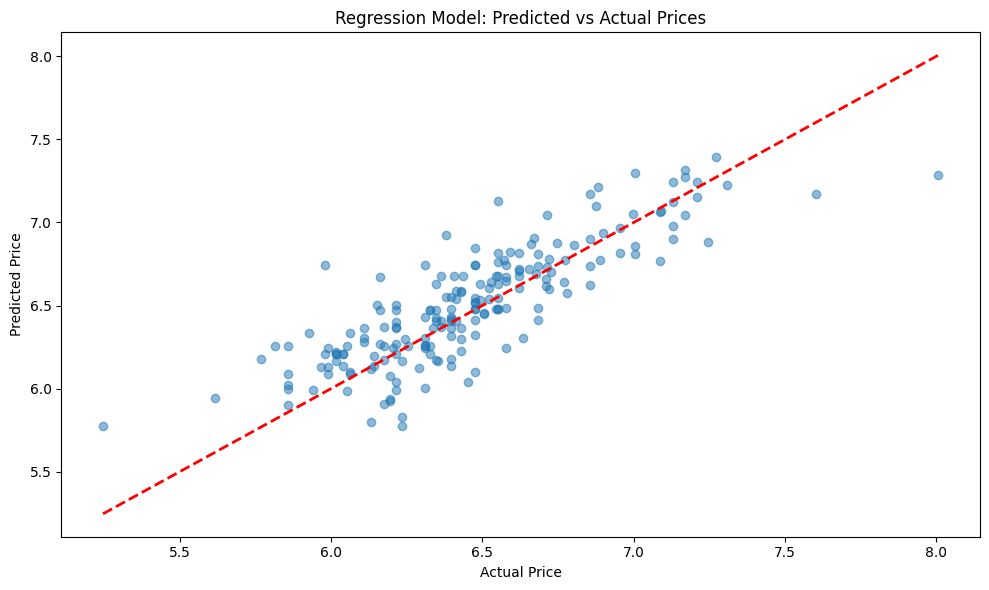

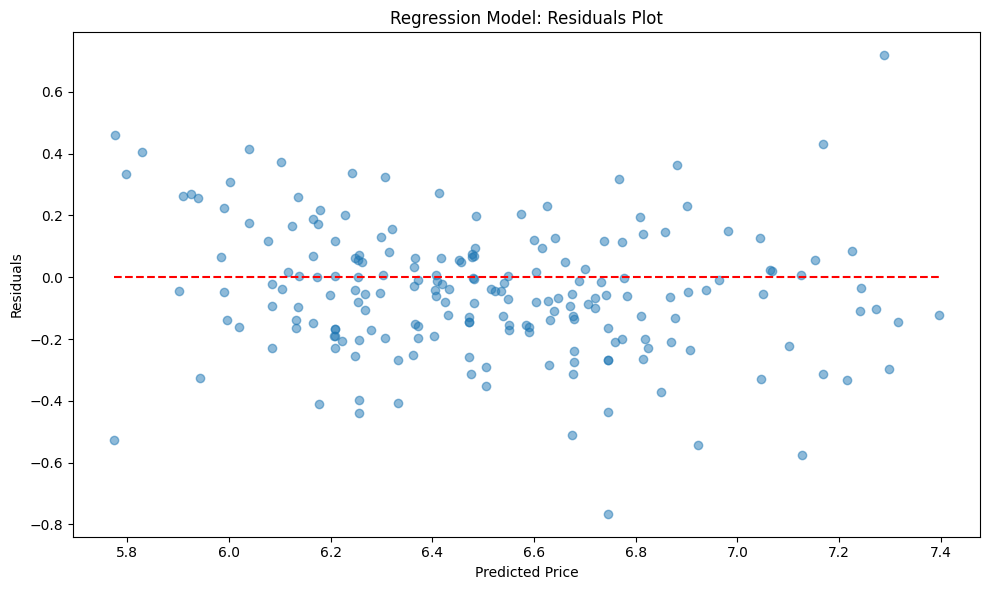

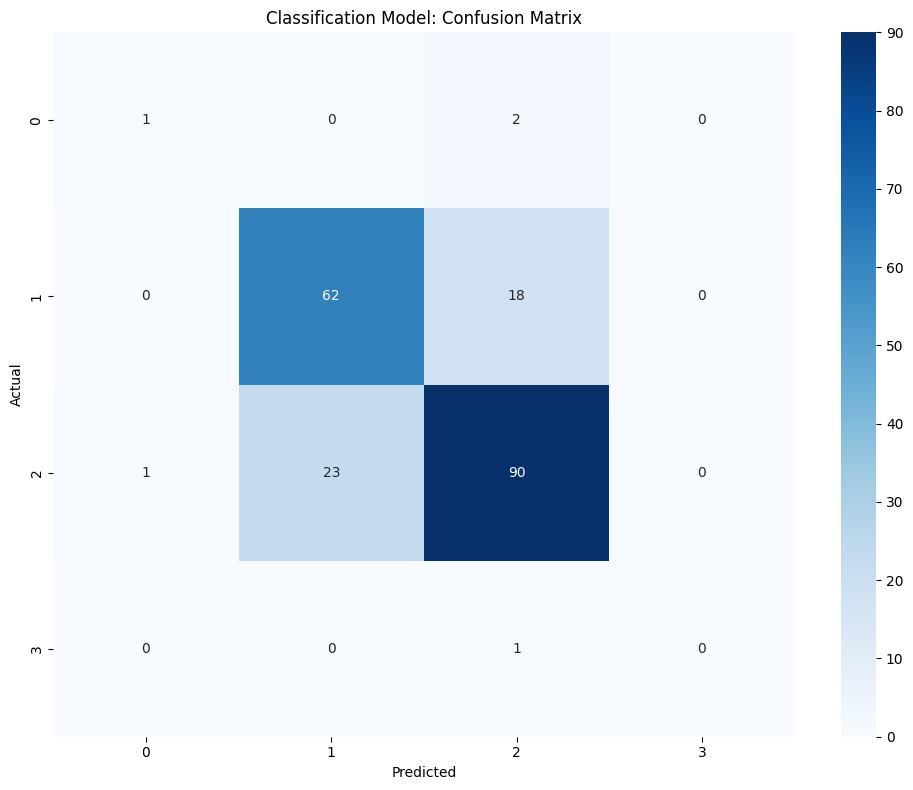

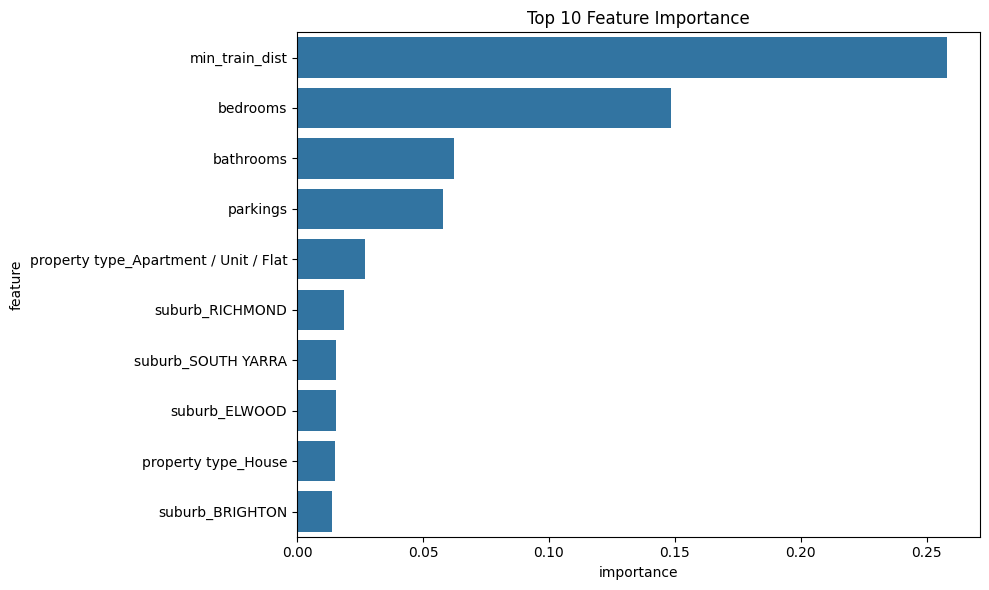

Regression Model Performance:
Mean Squared Error: 0.05
R-squared Score: 0.68

Classification Model Performance:
Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

        High       0.50      0.33      0.40         3
         Low       0.73      0.78      0.75        80
      Medium       0.81      0.79      0.80       114
   Very High       0.00      0.00      0.00         1

    accuracy                           0.77       198
   macro avg       0.51      0.47      0.49       198
weighted avg       0.77      0.77      0.77       198



/home/lqp303203/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lqp303203/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lqp303203/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report

# Load the data
data = pd.read_csv('../data/curated/preprocessed properties.csv')

# Clean and preprocess the data
data['price'] = data['price (AUD per week)']
data['log_rental_price'] = np.log(data['price'])
data['bedrooms'] = data['bedrooms'].fillna(0)

# Create price categories for classification
data['price_category'] = pd.cut(data['price per bedroom'], bins=[0, 300, 600, 900, np.inf],
                                labels=['Low', 'Medium', 'High', 'Very High'])

# Split features and target
X = data[['bedrooms', 'bathrooms', 'parkings', 'property type', 'suburb', 'min_train_dist']]
y_regression = data['log_rental_price']
y_classification = data['price_category']

# Split the data
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_regression, y_classification, test_size=0.2, random_state=42)

# Create preprocessor
numeric_features = ['bedrooms', 'bathrooms', 'parkings', 'min_train_dist']
categorical_features = ['property type', 'suburb']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Regression Model
reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

reg_model.fit(X_train, y_reg_train)
y_reg_pred = reg_model.predict(X_test)

# Classification Model
class_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

class_model.fit(X_train, y_class_train)
y_class_pred = class_model.predict(X_test)

# Visualization 1: Regression Model - Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Regression Model: Predicted vs Actual Prices')
plt.tight_layout()
plt.show()

# Visualization 2: Regression Model - Residuals Plot
residuals = y_reg_test - y_reg_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_reg_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_reg_pred.min(), xmax=y_reg_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Regression Model: Residuals Plot')
plt.tight_layout()
plt.show()

# Visualization 3: Classification Model - Confusion Matrix
cm = confusion_matrix(y_class_test, y_class_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Classification Model: Confusion Matrix')
plt.tight_layout()
plt.show()

# Visualization 4: Classification Model - Feature Importance
feature_importance = class_model.named_steps['classifier'].feature_importances_
feature_names = (numeric_features +
                 class_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

# Print model performance metrics
print("Regression Model Performance:")
print(f"Mean Squared Error: {mean_squared_error(y_reg_test, y_reg_pred):.2f}")
print(f"R-squared Score: {r2_score(y_reg_test, y_reg_pred):.2f}")

print("\nClassification Model Performance:")
print(f"Accuracy: {class_model.score(X_test, y_class_test):.2f}")
print("\nClassification Report:")
print(classification_report(y_class_test, y_class_pred))